In [1]:
import sys
sys.path.append("/Users/nicoherrig/Desktop/projects/Multi-armed Bandit RL/src/bandit_env") # local path
sys.path.append("/Users/nicoherrig/Desktop/projects/Multi-armed Bandit RL/src/agents")
sys.path.append("/Users/nicoherrig/Desktop/projects/Multi-armed Bandit RL/src")

In [2]:
from bandit_problem import stochastic_bandit # environment import
from utilities import Multiarmed_Bandit
from agents import EpsilonGreedyAgent, RandomAgent # agents import

In [3]:
# defining test environment

env = stochastic_bandit(size = 10) # 10-armed stochastic bandit as test case
agent_eps = EpsilonGreedyAgent(env = env, epsilon= 0.2, name = "Epsilon Agent")
agent_random = RandomAgent(env = env, name = "Random Agent")

Bandit_eps = Multiarmed_Bandit(environment= env, agent=agent_eps)
Bandit_random = Multiarmed_Bandit(environment= env, agent=agent_random)

In [4]:
Bandit_eps.execute(episodes=1000)


action: 6 reward:  0.20345096190997913 regret: 0.8110404805727325
action: 7 reward:  -0.5371124165431126 regret: 1.5516038590258243
action: 6 reward:  -0.5834704980407693 regret: 1.597961940523481
action: 0 reward:  -0.7148276107432803 regret: 1.7293190532259919
action: 1 reward:  -1.9002123390781154 regret: 2.914703781560827
action: 2 reward:  0.3887366301714522 regret: 0.6257548123112594
action: 2 reward:  0.8380684349567561 regret: 0.17642300752595552
action: 2 reward:  0.010996620211765284 regret: 1.0034948222709463
action: 2 reward:  2.196338557300397 regret: -1.1818471148176852
action: 2 reward:  -0.6649743366098988 regret: 1.6794657790926104
action: 2 reward:  1.9255504558739382 regret: -0.9110590133912266
action: 2 reward:  1.3388271979335098 regret: -0.3243357554507982
action: 2 reward:  1.6486005788605156 regret: -0.634109136377804
action: 2 reward:  1.0798144797737639 regret: -0.06532303729105227
action: 2 reward:  -1.2148964273773408 regret: 2.2293878698600524
action: 9 rew

In [5]:
Bandit_random.execute(episodes=1000)

action: 2 reward:  0.7936742539815478 regret: 0.22081718850116383
action: 0 reward:  -0.9661661639600133 regret: 1.9806576064427248
action: 0 reward:  -0.890894380275196 regret: 1.9053858227579075
action: 5 reward:  -1.278223747090842 regret: 2.2927151895735536
action: 3 reward:  0.1652521296447078 regret: 0.8492393128380038
action: 1 reward:  -2.2354543285229065 regret: 3.249945771005618
action: 2 reward:  -0.32863449525945443 regret: 1.343125937742166
action: 8 reward:  -0.002851337761435202 regret: 1.0173427802441468
action: 6 reward:  -0.5889946060329435 regret: 1.6034860485156552
action: 6 reward:  -1.3846292526203665 regret: 2.399120695103078
action: 1 reward:  -0.08160419717022552 regret: 1.096095639652937
action: 2 reward:  0.7334526471203954 regret: 0.28103879536231624
action: 9 reward:  -0.1341867400441732 regret: 1.1486781825268848
action: 0 reward:  -0.05087274229519767 regret: 1.0653641847779092
action: 8 reward:  1.3204001384643154 regret: -0.30590869598160375
action: 8 r

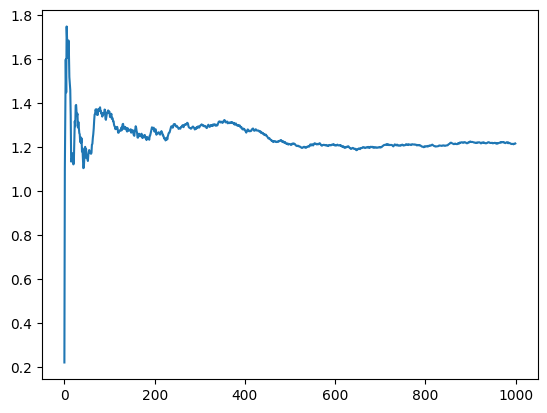

In [11]:
Bandit_random.average_regrets(plot = True)